In [2]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # 필요한 모듈을 가져옵니다.

from matplotlib.backends.backend_agg import FigureCanvasAgg

In [3]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import EvalCallback
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback

In [4]:
from scheduler_env.customEnv_repeat import SchedulingEnv

In [5]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

In [6]:
def print_result(info, detail_mode = False):
    current_repeats = info['current_repeats']
    print(f"Current Repeats\t\t\t:\t{current_repeats}")

    # 최종 점수 출력
    reward = info["reward"]
    print(f"Goal reached! Final score\t:\t{reward:.2f}")

    # 최종 완료 시간 출력
    env = info["env"]
    print(f"Finish Time / Target Time\t:\t{info['finish_time']} / {int(env.target_time)}")

    # jobs 생성
    jobs = []
    job_deadlines = info['job_deadline']
    job_tardiness = info['job_time_exceeded']
    index = 0

    if detail_mode:
        for repeat in current_repeats:
            for r in range(repeat):
                deadline = job_deadlines[index+r]
                tardiness = job_tardiness[index+r]
                print(f"Job {index + 1} - Repeat {r + 1}\t\t:\tTardiness/Deadline = {tardiness}/{deadline}")
            index += 1
        
    for job_id, repeat in enumerate(current_repeats, 1):
        job_info = {
            'job_id': job_id,
            'tardiness': job_tardiness[index:index+repeat],
            'deadline': job_deadlines[index:index+repeat]
        }
        jobs.append(job_info)
        index += repeat

    
    # Calculate Tardiness/Deadline ratios and assign colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
              '#aec7e8', '#ffbb78']  # Color palette for jobs
    
    ratios = []
    x_labels = []
    bar_colors = []
    x_positions = []
    
    current_x = 0
    for job in jobs:
        ratio = [t/d if d != 0 else 0 for t, d in zip(job['tardiness'], job['deadline'])]
        ratios.extend(ratio)
        x_labels.extend([f'Job {job["job_id"]} - Repeat {i+1}' for i in range(len(ratio))])
        bar_colors.extend([colors[job['job_id'] - 1]] * len(ratio))
        x_positions.extend([current_x + i for i in range(len(ratio))])
        current_x += len(ratio) + 1  # Add space between different jobs

    # Calculate and print the average Tardiness/Deadline ratio
    avg_ratio = np.mean(ratios)
    print(f"Average Tardiness/Deadline Ratio:\t{avg_ratio:.2f}")
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.8
    ax.bar(x_positions, ratios, width=bar_width, color=bar_colors)
    
    # Set x-ticks and x-tick labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=90, ha='center')
    ax.set_xlabel('Job - Repeat')
    ax.set_ylabel('Tardiness/Deadline Ratio')
    ax.set_title('Tardiness/Deadline Ratio per Job Repeat')
    
    # Legend
    unique_jobs = list(set([f'Job {job["job_id"]}' for job in jobs]))
    legend_patches = [mpatches.Patch(color=colors[i], label=unique_jobs[i]) for i in range(len(unique_jobs))]
    legend_patches.sort(key=lambda x: int(x.get_label().split()[1]))
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [7]:
env_2_3_3 = SchedulingEnv(machine_config_path= "instances/Machines/v0-2.json", job_config_path = "instances/Jobs/v0-3x3-deadline.json", job_repeats_params = [(2, 1)] * 3)

In [8]:
env_8_12_3 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", job_repeats_params = [(3, 1)] * 12)

In [9]:
env_8_12_1_t = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", job_repeats_params = [(1, 1)] * 12, test_mode = True)

In [20]:
env_8_12_8 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-hard.json", job_repeats_params = [(8, 3)] * 12)

In [10]:
env = env_8_12_1_t
check_env(env)

In [ ]:
step = 0
obs, info = env.reset()

while True:
    step += 1
    action = env.action_space.sample()    
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    
    if done:
        #print_result(info)
        env.render()
        break

In [11]:
log_path = "./logs/tmp/1"
# set up logger
new_logger = configure(log_path, ["stdout", "csv", "tensorboard"])

# Create the evaluation environment
eval_env = env
obs, info = eval_env.reset()

# Create the EvalCallback
eval_callback = EvalCallback(eval_env, best_model_save_path=log_path,
                             log_path=log_path, eval_freq=10000,
                             deterministic=True, render=False)

# Create the MaskableEvalCallback
maskable_eval_callback = MaskableEvalCallback(eval_env, best_model_save_path=log_path,
                             log_path=log_path, eval_freq=10000,
                             deterministic=True, render=False)

Logging to ./logs/tmp/1


In [12]:
### 하이퍼파라미터 목록
params = {
    # "policy_kwargs" : dict(net_arch=[dict(pi=[128, 64, 64], vf=[128, 64, 64])]),
    # "gamma" : 1.0,
    }

In [ ]:
model = MaskablePPO('MultiInputPolicy', env, verbose=1)#, gamma=params["gamma"] policy_kwargs = params["policy_kwargs"])
model.set_logger(new_logger)
model.learn(500000, callback=maskable_eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37       |
|    ep_rew_mean     | 19.8     |
| time/              |          |
|    fps             | 331      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 37          |
|    ep_rew_mean          | 20.4        |
| time/                   |             |
|    fps                  | 266         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014762936 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [15]:
!tensorboard --logdir=./logs/tmp/1

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.14.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [11]:
import os
import shutil

log_dir = "./logs/tmp/1"

# 디렉토리 내 모든 파일과 서브 디렉토리 삭제
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
    print(f"{log_dir} 디렉토리와 그 안의 모든 내용이 삭제되었습니다.")
else:
    print(f"{log_dir} 디렉토리가 존재하지 않습니다.")

# 디렉토리 재생성 (필요한 경우)
os.makedirs(log_dir, exist_ok=True)
print(f"{log_dir} 디렉토리가 생성되었습니다.")

PermissionError: [WinError 32] 다른 프로세스가 파일을 사용 중이기 때문에 프로세스가 액세스 할 수 없습니다: './logs/tmp/1\\progress.csv'

In [11]:
model.save("MaskablePPO_normal_repeat_hard")

In [17]:
def random_tardiness_simulation(repeats):
    j = []
    for r in repeats:
        j.append((r, 1))

    test_env = env
    step = 0
    obs, info = test_env.reset()
    while True:
        step += 1
        action = test_env.action_space.sample()    
        obs, reward, terminated, truncated, info = test_env.step(action)
        done = terminated or truncated
        info["reward"] = reward
        info["env"] = test_env
        
        if done:
            print_result(info)
            test_env.render()
            break

Current Repeats			:	[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Goal reached! Final score	:	77.16
Finish Time / Target Time	:	1300 / 1000
Average Tardiness/Deadline Ratio:	0.08


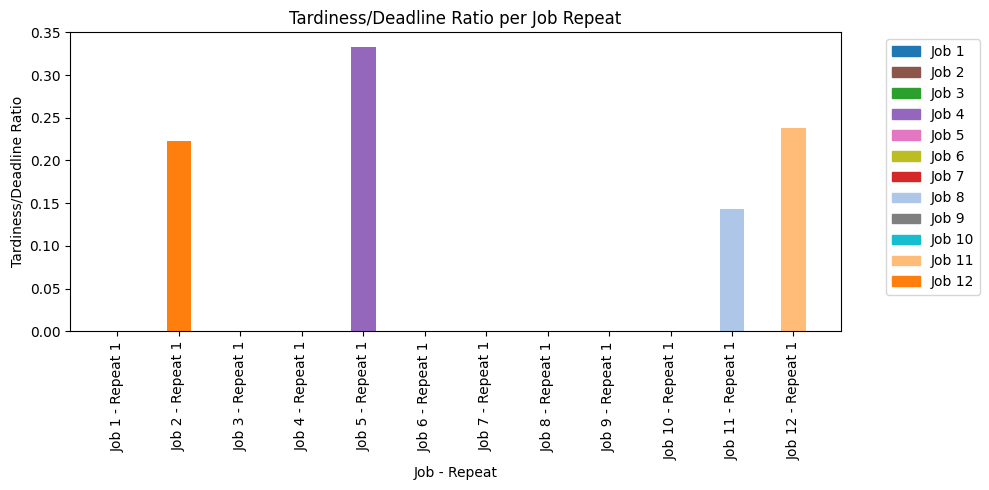

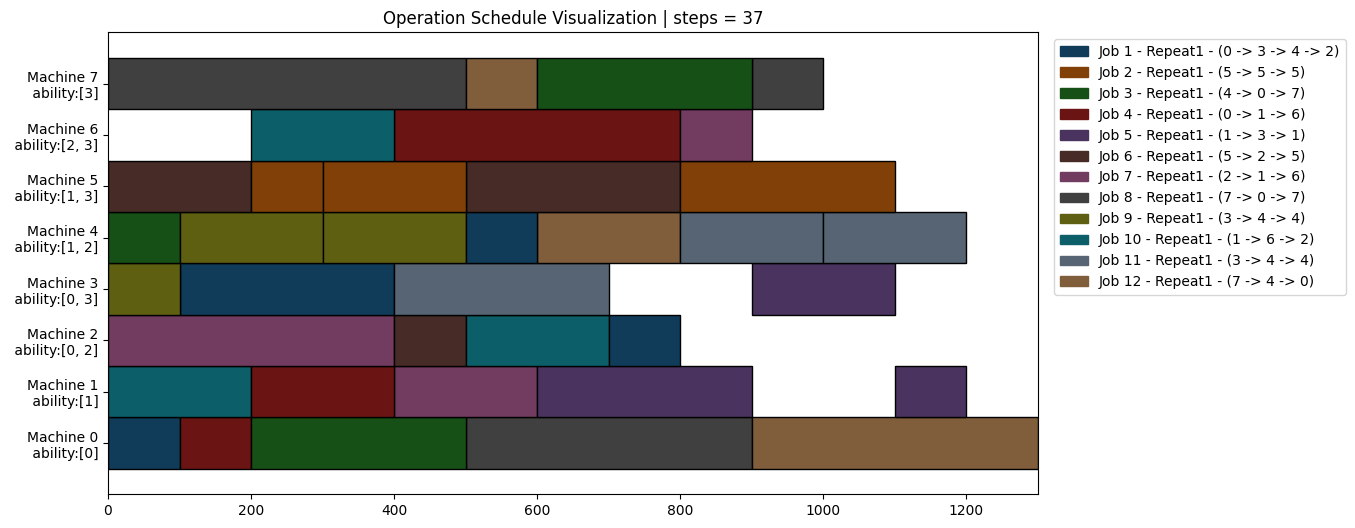




---------------------------Random Simmulation---------------------------
Current Repeats			:	[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Goal reached! Final score	:	10.87
Finish Time / Target Time	:	2100 / 1000
Average Tardiness/Deadline Ratio:	0.51


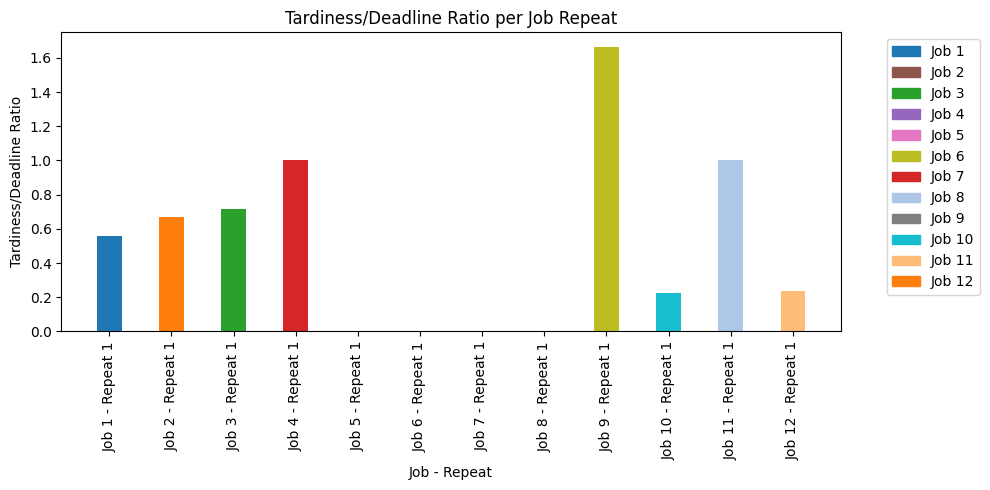

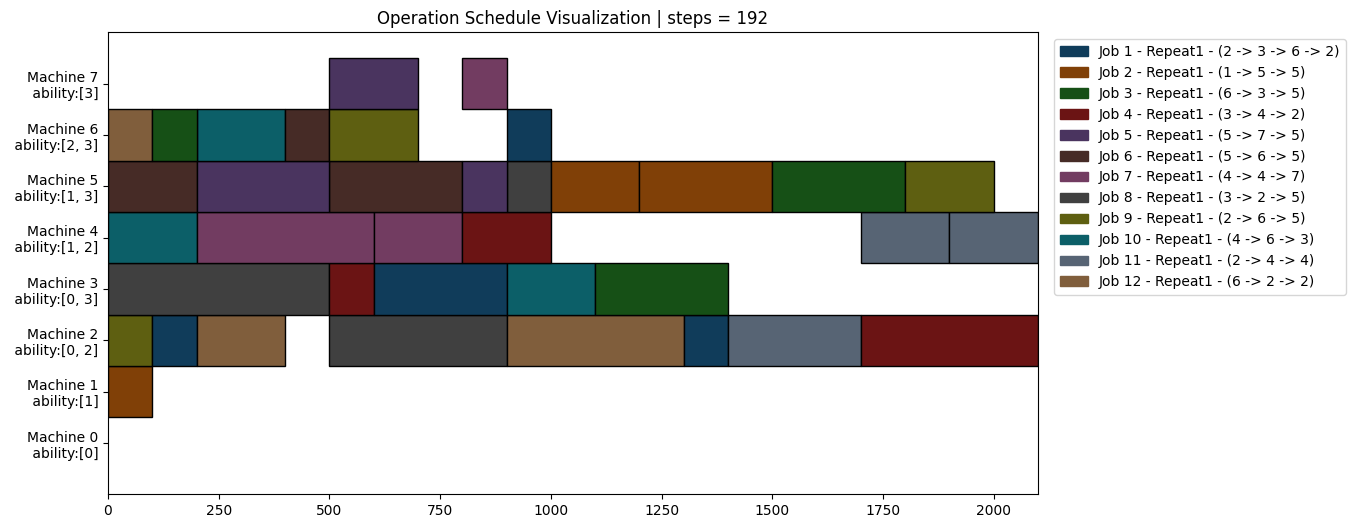

In [18]:
obs, info = env.reset()
while True:
    action_masks = env.action_masks()
    action, _states = model.predict(obs, action_masks=action_masks, deterministic = True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    info["reward"] = reward
    info["env"] = env
    if done:
        print_result(info, detail_mode = False)
        env.render()
        break


print()
print()
print()
print("---------------------------Random Simmulation---------------------------")
random_tardiness_simulation(info["current_repeats"])

In [26]:
# job_paths와 machine_paths를 포함하는 목록
job_paths = ["instances/Jobs/v0-12-repeat.json"]
machine_paths = ["instances/Machines/v0-8.json"]

def make_env(job_path, machine_path, test_mode, job_repeats_params):
    def _init():
        env = SchedulingEnv(job_config_path=job_path, machine_config_path=machine_path, job_repeats_params = job_repeats_params, weight_final_time = 50, weight_job_deadline = 50, weight_op_rate = 0, test_mode = test_mode)
        return env
    return _init

envs = [make_env(job_paths[0], machine_paths[0], True, [(3, 1)]*12), make_env(job_paths[0], machine_paths[0], False, [(3, 1)]*12)]

vec_env = SubprocVecEnv(envs)

KeyboardInterrupt: 